# Exploration of Bus Route 116 Data

In [1]:
import pandas as pd
from datetime import datetime, timedelta
%matplotlib inline

## Load route 116

In [2]:
data = pd.read_csv("data/116", sep='\t',header=None)

## Metadata
GPS,车辆编号,翻译线路编号（没有为-）,方向（0上行1下行，-1表示没有）,wgs84坐标系经度,纬度,校准后数据时间,速度（不一定有，没有-1）,角度（不一定有，没有-1）,原始数据接收时间，运营/非运营(1表示非运营,0表示运营,-1表示未知),线路编号（没有为-）,指定线路编号（没有为-）,数据来源(0：公交/交委、其他你们可以不用)，8位随机数字，原始数据时间

In [3]:
data.columns = ["GPS", "licence_plate_number","route","direction","longitude","latitude",
               "calibrated_time","velocity","angle","raw_time"]

In [4]:
data.angle.unique()

array([-1])

In [5]:
data.velocity.unique()

array([-1])

## Select certain fields

In [6]:
data = data[["licence_plate_number","route","longitude","latitude","calibrated_time","raw_time"]]

In [7]:
data.head()

,licence_plate_number,route,longitude,latitude,calibrated_time,raw_time
0,粤E19204,116,113.14631,23.02181,2015-07-01 00:01:30,2015-07-01 00:01:34
1,粤E19207,116,113.09928,23.05066,2015-07-01 00:01:30,2015-07-01 00:01:34
2,粤E16952,116,113.14620,23.02110,2015-07-01 00:01:25,2015-07-01 00:01:34
3,粤E19205,116,113.14623,23.02135,2015-07-01 00:01:31,2015-07-01 00:01:35
4,粤E17022,116,113.14618,23.02138,2015-07-01 00:01:30,2015-07-01 00:01:35


### How many records are there?

In [8]:
data.shape

(9896391, 6)

## Clean the data

### Throw away the records with inappropriate time range

In [9]:
# Generate all unique seconds, minutes, hours.
now = datetime(2000, 1, 1, 0, 0, 0)
last = datetime(2000, 1, 2, 0, 0, 0)
delta = timedelta(seconds=1)

seconds = set()
minutes = set()
hours = set()
while now < last:
    second = now.strftime('%S')
    minute = now.strftime('%M')
    hour = now.strftime('%H')
    seconds.add(second)
    minutes.add(minute)
    hours.add(hour)
    now += delta
seconds = list(seconds)
minutes = list(minutes)
hours = list(hours)

# Generate all unique months.
months=["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]

In [10]:
for time in ["calibrated_time", "raw_time"]:
    data = data[data[time].str[-2:].isin(seconds)]
    data = data[data[time].str[-5:-3].isin(minutes)]
    data = data[data[time].str[-8:-6].isin(hours)]
    data = data[data[time].str[5:7].isin(months)]
    data = data[data[time].str[:4].isin(["2015"])]

### How many records remain after throwing away the records with inappropriate time range?

In [11]:
data.shape

(9889251, 6)

In [12]:
print(str(round((-(9889252 / 9896391 - 1)*100),3)) + "% of records are removed")

0.072% of records are removed


### Throw away the records with inappropriate longitude and latitude

In [19]:
data["longitude"].describe()

count    9.889251e+06
mean     1.131076e+02
std      8.412117e-01
min     -2.046620e+03
25%      1.130974e+02
50%      1.131178e+02
75%      1.131462e+02
max      1.130355e+03
Name: longitude, dtype: float64

In [20]:
data["latitude"].describe()

count    9.889251e+06
mean     2.302936e+01
std      7.356210e-01
min      3.000000e-05
25%      2.302088e+01
50%      2.302211e+01
75%      2.304831e+01
max      1.646518e+03
Name: latitude, dtype: float64

In [ ]:
data = data[data["latitude"].]

## Sort records by bus and time

In [13]:
data.sort_values(["licence_plate_number","calibrated_time"], inplace=True)

In [16]:
data['longitude'].describe()

count    9.889251e+06
mean     1.131076e+02
std      8.412117e-01
min     -2.046620e+03
25%      1.130974e+02
50%      1.131178e+02
75%      1.131462e+02
max      1.130355e+03
Name: longitude, dtype: float64

## Throw away records when the bus is not working

In [35]:
data.tail(200)

,licence_plate_number,route,longitude,latitude,calibrated_time,raw_time
9891652,粤E19212,116,113.14610,23.02021,2015-07-31 23:28:07,2015-07-31 23:28:10
9891680,粤E19212,116,113.14610,23.02023,2015-07-31 23:28:19,2015-07-31 23:28:24
9891715,粤E19212,116,113.14610,23.02021,2015-07-31 23:28:31,2015-07-31 23:28:35
9891743,粤E19212,116,113.14610,23.02021,2015-07-31 23:28:43,2015-07-31 23:28:47
9891778,粤E19212,116,113.14608,23.02021,2015-07-31 23:28:55,2015-07-31 23:28:59
9891792,粤E19212,116,113.14608,23.02021,2015-07-31 23:28:55,2015-07-31 23:29:04
9891808,粤E19212,116,113.14608,23.02021,2015-07-31 23:29:07,2015-07-31 23:29:12
9891838,粤E19212,116,113.14608,23.02023,2015-07-31 23:29:19,2015-07-31 23:29:24
9891866,粤E19212,116,113.14608,23.02023,2015-07-31 23:29:31,2015-07-31 23:29:35
9891902,粤E19212,116,113.14608,23.02023,2015-07-31 23:29:43,2015-07-31 23:29:46


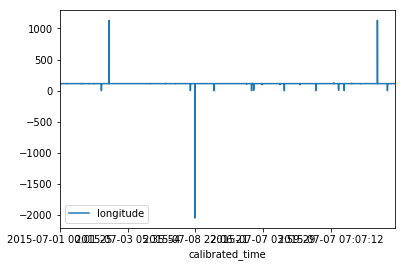

In [14]:
data.plot(x="calibrated_time",y="longitude")

### How many records for each bus?

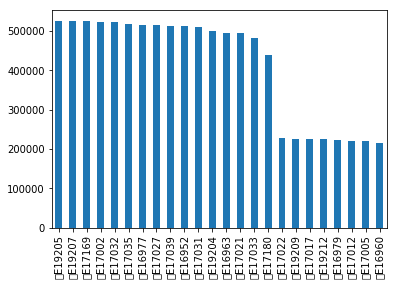

In [30]:
data["licence_plate_number"].value_counts().plot(kind="bar")

## Transform raw_time and calibrated_time to datetime object

In [207]:
data["raw_time"] = data["raw_time"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))
data["calibrated_time"] = data["calibrated_time"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))

In [213]:
data["calibrated_time"] = data["calibrated_time"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))

In [217]:
elapsed_time = data["raw_time"] - data["calibrated_time"]
elapsed_time.head()

0   00:00:04
1   00:00:04
2   00:00:09
3   00:00:04
4   00:00:05
dtype: timedelta64[ns]

### What is the distribution of the time difference between raw_time and calibrated_time?

In [242]:
elapsed_time.describe()

count                   9889252
mean     0 days 00:00:15.524539
std      0 days 01:23:20.001776
min           -2 days +13:31:04
25%             0 days 00:00:03
50%             0 days 00:00:04
75%             0 days 00:00:05
max           181 days 00:00:04
dtype: object

### How frequent does GPS record data?

In [246]:
data[data['licence_plate_number']=='粤E19204'].sort_values("calibrated_time")

,GPS,licence_plate_number,route,direction,longitude,latitude,calibrated_time,velocity,angle,raw_time
0,GPS,粤E19204,116,-1,113.14631,23.02181,2015-07-01 00:01:30,-1,-1,2015-07-01 00:01:34
19,GPS,粤E19204,116,-1,113.14631,23.02181,2015-07-01 00:01:35,-1,-1,2015-07-01 00:01:39
39,GPS,粤E19204,116,-1,113.14631,23.02181,2015-07-01 00:01:40,-1,-1,2015-07-01 00:01:44
57,GPS,粤E19204,116,-1,113.14631,23.02181,2015-07-01 00:01:45,-1,-1,2015-07-01 00:01:47
82,GPS,粤E19204,116,-1,113.14631,23.02181,2015-07-01 00:01:50,-1,-1,2015-07-01 00:01:54
102,GPS,粤E19204,116,-1,113.14631,23.02181,2015-07-01 00:01:55,-1,-1,2015-07-01 00:01:58
124,GPS,粤E19204,116,-1,113.14631,23.02181,2015-07-01 00:02:00,-1,-1,2015-07-01 00:02:05
132,GPS,粤E19204,116,-1,113.14631,23.02181,2015-07-01 00:02:00,-1,-1,2015-07-01 00:02:06
137,GPS,粤E19204,116,-1,113.14631,23.02181,2015-07-01 00:02:05,-1,-1,2015-07-01 00:02:09
159,GPS,粤E19204,116,-1,113.14631,23.02181,2015-07-01 00:02:10,-1,-1,2015-07-01 00:02:14


In [257]:
data["calibrated_time"].diff().median()

Timedelta('0 days 00:00:00')

### Answer: GPS records data approximately every 5 seconds